In [2]:
import numpy as np
import pandas as pd
import gurobipy as gb
import matplotlib.pyplot as plt

In [3]:
# read file
FILE_NAME = "/Users/bianhanzhang/Desktop/data/asset pool/SP500_100_assets_pool2.csv"
FILE_NAME2 ="/Users/bianhanzhang/Desktop/Coding/SP500_100_assets_pool2.csv" 
data = pd.read_csv(FILE_NAME2)
data.head(3)

mean_return        MO       BLL      NTAP       AFL       AAP       SRE  \
0     0.001138  0.000102  0.000058  0.000071  0.000040  0.000037  0.000035   
1    -0.000027  0.000058  0.000216  0.000172  0.000069  0.000120  0.000053   
2     0.000937  0.000071  0.000172  0.000312  0.000080  0.000142  0.000044   

        MGM       DHI       AON  ...        LH      INCY       ALB      TROW  \
0  0.000049  0.000049  0.000062  ...  0.000053  0.000039  0.000043  0.000026   
1  0.000093  0.000088  0.000180  ...  0.000102  0.000101  0.000072  0.000066   
2  0.000112  0.000101  0.000198  ...  0.000120  0.000113  0.000081  0.000076   

        PFE        HP       BEN        EA       NSC       ECL  
0  0.000030  0.000052  0.000043  0.000075  0.000048  0.000031  
1  0.000041  0.000124  0.000082  0.000197  0.000118  0.000051  
2  0.000011  0.000124  0.000098  0.000230  0.000114  0.000032  

[3 rows x 101 columns]

In [4]:
# mean return of 100 selected bonds
SP_mean_rtn = np.reshape(np.array(data.iloc[:,0]),(100,1))

# covariance of 100 selected bonds
SP_cov_rtn = np.array(data.iloc[:,1:])

In [43]:
def opt(rtn,cov,cardinality,n,min_po,max_po,risk_aversion_para):
    
    m = gb.Model()

    # variable
    weights = m.addMVar(n,lb=0,ub=1,name="weights")
    dv = m.addMVar(n,vtype = gb.GRB.BINARY,name="decision_variable")
    
    # model
    portfolio_return = gb.quicksum(weights[i] * rtn[i] for i in range(n))
    portfolio_risk = gb.quicksum(weights[i] * weights[j] * cov_rtn
                            for i in range(n)
                            for j in range(n)
                            for cov_rtn in [cov[i,j]])
    m.setObjective(risk_aversion_para * portfolio_risk - (1 - risk_aversion_para) * \
                   portfolio_return,gb.GRB.MINIMIZE)
    
    # weight constraint
    m.addConstr(weights.sum() == 1,"weights constraint")
#     # force x to be 0 if not selected
    m.addConstr(weights <= dv,"Indicator")
#     # holding position of one asset exceed minimum position
    m.addConstr(weights >= dv * min_po,"Minimum Position")
#     # holding position of one asset exceed maximum position
    m.addConstr(weights <= dv * max_po,"Maximum Position")
#     # Cardinality constraint
#     m.addConstr(dv.sum() == cardinality,"cardinality constraint")
    
    m.optimize()
    if m.status == gb.GRB.OPTIMAL:
        return weights.X,dv.X
    else:
        return None,None

In [6]:
# chromosome,dv = opt(SP_mean_rtn,SP_cov_rtn,15,100,0.001,0.40,0.5)

In [7]:
def cal_ann_return_risk(weight, mean_rtn, cov_rtn):
    """calculate annual return and risk"""
    ann_rtn = (1 + np.dot(weight, mean_rtn)) ** 252 - 1  # trading days: 252
    variance = (1 + np.dot(np.dot(weight, cov_rtn),weight.T)) ** 252 - 1
    ann_risk = np.sqrt(variance)            
    result = np.array([ann_rtn.item(),ann_risk])
    return result

In [18]:
def efficient_frontier(rtn,cov):
    ef_set = []

    # risk_aversion parameter
    risk_aversion_para = np.linspace(0.01,1,100)
    # cardinality
    cardinality = 15
    # dimension
    n = 100
    # minimum expected return
    min_return = 0.15
    # minimum position
    min_po = 0.001
    # maximum position
    max_po = 0.40
    
    for i in range(100):
        risk_para = risk_aversion_para[i]
        chromosome,dv = opt(rtn,cov,cardinality,n,min_po,max_po,risk_para)
        chromosome[dv == 0] = 0
        ef = cal_ann_return_risk(chromosome,rtn,cov)
        ef_set.append(ef)
    return ef_set

In [44]:
ucef_set = efficient_frontier(SP_mean_rtn,SP_cov_rtn)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonzeros
Model fingerprint: 0x2c2b627c
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-05, 2e-03]
  QObjective range [5e-08, 1e-05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0005870
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.539679e-03, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-05, 2e-03]
  QObjective range [3e-07, 7e-05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0005523
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.453664e-03, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00145    0    1   -0.00055   -0.00145   163%     -    0s
H    0     0                      -0.0014537   -0.00145  0.00%     -    0s
     0     0   -0.00145    0    1   -0.00145   -0.0014

  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0005175
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.367648e-03, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00137    0    1   -0.00052   -0.00137   164%     -    0s
H    0     0                      -0.0013676   -0.00137  0.00%     -    0s
     0     0   -0.00137    0    1   -0.00137   -0.00137  0.00%     -    0s

Explored 1 nodes (51 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.00136765 -0.000517513 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.367648


Root relaxation: objective -1.281633e-03, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00128    0    1   -0.00048   -0.00128   165%     -    0s
H    0     0                      -0.0012816   -0.00128  0.00%     -    0s
     0     0   -0.00128    0    1   -0.00128   -0.00128  0.00%     -    0s

Explored 1 nodes (47 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.00128163 -0.000482769 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.281632898254e-03, best bound -1.281632898254e-03, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonzer

H    0     0                      -0.0011956   -0.00120  0.00%     -    0s
     0     0   -0.00120    0    1   -0.00120   -0.00120  0.00%     -    0s

Explored 1 nodes (37 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.00119562 -0.000448025 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.195617438235e-03, best bound -1.195617438235e-03, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonzeros
Model fingerprint: 0x2c75440f
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-05, 1e-03]
  QObjective range [1e-06, 3e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00


Solution count 2: -0.0011096 -0.000413281 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.109601978215e-03, best bound -1.109601978215e-03, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonzeros
Model fingerprint: 0x7d188424
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-05, 1e-03]
  QObjective range [1e-06, 3e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0004063
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

R

Model fingerprint: 0xb1df5f90
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-05, 1e-03]
  QObjective range [1e-06, 4e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0003716
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.006433e-03, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00101    0    1   -0.00037   -0.00101   171%     -    0s
H    0     0                      -0.0010064   -0.00101  0.00%     -    0s

Explored 1 nodes (32 si

Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.206246e-04, 55 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00092    0    2   -0.00034   -0.00092   173%     -    0s
H    0     0                      -0.0009206   -0.00092  0.00%     -    0s
     0     0   -0.00092    0    2   -0.00092   -0.00092  0.00%     -    0s

Explored 1 nodes (55 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.000920625 -0.000336844 

Optimal solution found (tolerance 1.00e-04)
Best objective -9.206245623340e-04, best bound -9.206245623340e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical c

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00084    0    2   -0.00030   -0.00084   176%     -    0s
H    0     0                      -0.0008352   -0.00084  0.00%     -    0s
     0     0   -0.00084    0    2   -0.00084   -0.00084  0.00%     -    0s

Explored 1 nodes (48 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.000835198 -0.0003021 

Optimal solution found (tolerance 1.00e-04)
Best objective -8.351984943542e-04, best bound -8.351984943542e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonzeros
Model fingerprint: 0x84e6c5f1
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix 


Explored 1 nodes (51 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.000750054 -0.000267356 

Optimal solution found (tolerance 1.00e-04)
Best objective -7.500540794987e-04, best bound -7.500540794987e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonzeros
Model fingerprint: 0x6214ce4e
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-05, 9e-04]
  QObjective range [2e-06, 6e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0002604
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonzeros
Model fingerprint: 0xe458f908
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-05, 8e-04]
  QObjective range [2e-06, 6e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0002257
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -6.481403e-04, 55 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Un

Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-05, 7e-04]
  QObjective range [3e-06, 7e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0001909
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -5.633688e-04, 51 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00056    0    2   -0.00019   -0.00056   195%     -    0s
H    0     0                      -0.0005634   -0.00056  0.00%     -    0s
     0     0   -0.00056    0    2   -0.00056   -0.0005

  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0001562
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -4.789124e-04, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00048    0    3   -0.00016   -0.00048   207%     -    0s
H    0     0                      -0.0004789   -0.00048  0.00%     -    0s
     0     0   -0.00048    0    3   -0.00048   -0.00048  0.00%     -    0s

Explored 1 nodes (42 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.000478912 -0.000156176 

Optimal solution found (tolerance 1.00e-04)
Best objective -4.78912


Root relaxation: objective -3.966262e-04, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00040    0    3   -0.00012   -0.00040   227%     -    0s
H    0     0                      -0.0003966   -0.00040  0.00%     -    0s
     0     0   -0.00040    0    3   -0.00040   -0.00040  0.00%     -    0s

Explored 1 nodes (42 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.000396626 -0.000121432 

Optimal solution found (tolerance 1.00e-04)
Best objective -3.966261770656e-04, best bound -3.966261770656e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonze

H    0     0                      -0.0003166   -0.00032  0.00%     -    0s
     0     0   -0.00032    0    5   -0.00032   -0.00032  0.00%     -    0s

Explored 1 nodes (44 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -0.000316571 -8.66875e-05 

Optimal solution found (tolerance 1.00e-04)
Best objective -3.165710117356e-04, best bound -3.165710117356e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonzeros
Model fingerprint: 0xa35c1f2a
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [7e-06, 4e-04]
  QObjective range [3e-06, 9e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+0


Solution count 2: -0.000239438 -5.19435e-05 

Optimal solution found (tolerance 1.00e-04)
Best objective -2.394381968911e-04, best bound -2.394381968911e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonzeros
Model fingerprint: 0xe8fc2801
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [6e-06, 3e-04]
  QObjective range [4e-06, 1e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000450
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)



CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301 rows, 200 columns and 700 nonzeros
Model fingerprint: 0x2981f7cf
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-06, 3e-04]
  QObjective range [4e-06, 1e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000103
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.509349e-04, 32 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   

Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-06, 2e-04]
  QObjective range [4e-06, 1e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000245
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -8.032405e-05, 31 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00008    0    7    0.00002   -0.00008   428%     -    0s
H    0     0                      -0.0000803   -0.00008  0.00%     -    0s
     0     0   -0.00008    0    7   -0.00008   -0.00008  0.00%     -    0s

Explored 1 nodes (31 simplex iterations) in 0.01 seconds (0.00 work units)
Th

Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 500 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.424728e-05, 45 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.00001    0   14    0.00006   -0.00001   124%     -    0s
H    0     0                      -0.0000142   -0.00001  0.00%     -    0s
     0     0   -0.00001    0   14   -0.00001   -0.00001  0.00%     -    0s

Explored 1 nodes (45 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -1.42473e-05 5.92374e-05 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.424727671240e-05, best bound -1.424727671240e-05, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Da

Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective 3.414952e-05, 136 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00003    0   31    0.00009    0.00003  63.7%     -    0s
H    0     0                       0.0000341    0.00003  0.00%     -    0s
     0     0    0.00003    0   31    0.00003    0.00003  0.00%     -    0s

Explored 1 nodes (136 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 3.41496e-05 9.39814e-05 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.414960160724e-05, best bound 3.414960160724e-05, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical core

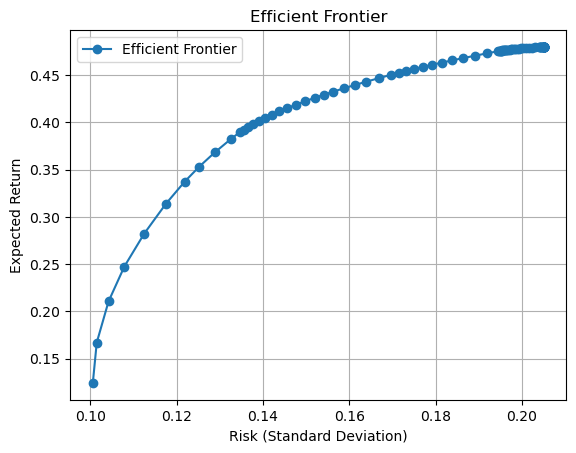

In [45]:
draw_ef(ucef_set)

In [19]:
ef_set = efficient_frontier(SP_mean_rtn,SP_cov_rtn)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0xdf3a6aea
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [3e-05, 2e-03]
  QObjective range [5e-08, 1e-05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0004617
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.529742e-03, 438 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

Found heuristic solution: objective -0.0004295
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.444682e-03, 444 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -0.0004805   -0.00144   201%     -    0s
*    0     0               0      -0.0014447   -0.00144  0.00%     -    0s

Explored 1 nodes (444 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -0.00144468 -0.000480542 -0.000429534 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.444682325853e-03, best bound -1.444682325853e-03, gap 0.0000%
Gurobi Optimizer version 11.0.2 build 

*    0     0               0      -0.0013586   -0.00136  0.00%     -    0s

Explored 1 nodes (438 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -0.00135857 -0.000449437 -0.000397338 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.358571714599e-03, best bound -1.358571714599e-03, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0x1600139d
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-05, 1e-03]
  QObjective range [5e-07, 1e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0003909
Preso


Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0x2489a6d7
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-05, 1e-03]
  QObjective range [8e-07, 2e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0003587
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.256421e-03, 438 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -0.0004121   -0.00126   205%     -    0s
*    0     0               0      -0

Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.169682e-03, 426 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -0.0003810   -0.00117   207%     -    0s
*    0     0               0      -0.0011697   -0.00117  0.00%     -    0s

Explored 1 nodes (426 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -0.00116968 -0.000381005 -0.000326507 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.169681536757e-03, best bound -1.169681536757e-03, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros



Solution count 3: -0.00108431 -0.0003499 -0.000294311 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.084305269236e-03, best bound -1.084305269236e-03, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0x01f01399
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-05, 1e-03]
  QObjective range [1e-06, 3e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0002879
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (10

Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-05, 1e-03]
  QObjective range [2e-06, 4e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0002557
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -9.820250e-04, 423 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -0.0003126   -0.00098   214%     -    0s
*    0     0               0      -0.0009820   -0.00098  0.00%     -    0s

Explored 1 nodes (423 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -0.00098

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -0.0002815   -0.00090   219%     -    0s
*    0     0               0      -0.0008973   -0.00090  0.00%     -    0s

Explored 1 nodes (420 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -0.000897261 -0.000281468 -0.00022348 

Optimal solution found (tolerance 1.00e-04)
Best objective -8.972612474665e-04, best bound -8.972612474665e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0xb86380f8
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-05, 1e-03]
 


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0x4d392c58
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-05, 9e-04]
  QObjective range [2e-06, 5e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0001848
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -7.956389e-04, 420 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0  

Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -7.112298e-04, 420 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -0.0002130   -0.00071   234%     -    0s
*    0     0               0      -0.0007112   -0.00071  0.00%     -    0s

Explored 1 nodes (420 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -0.00071123 -0.000213036 -0.000152649 

Optimal solution found (tolerance 1.00e-04)
Best objective -7.112298461687e-04, best bound -7.112298461687e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 phy


Explored 1 nodes (420 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -0.000626997 -0.000181931 -0.000120453 

Optimal solution found (tolerance 1.00e-04)
Best objective -6.269974665321e-04, best bound -6.269974665321e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0xc6af570b
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-05, 7e-04]
  QObjective range [3e-06, 7e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0001140
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 row

Model fingerprint: 0x4e42a78c
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e-05, 7e-04]
  QObjective range [3e-06, 7e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000818
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -5.260897e-04, 420 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -0.0001446   -0.00053   264%     -    0s
*    0     0               0      -0.0005261   -0.00053  0.00%     -    0s

Explored 1 nodes (420 


Root relaxation: objective -4.428098e-04, 417 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -0.0001135   -0.00044   290%     -    0s
*    0     0               0      -0.0004428   -0.00044  0.00%     -    0s

Explored 1 nodes (417 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -0.00044281 -0.000113499 -4.96225e-05 

Optimal solution found (tolerance 1.00e-04)
Best objective -4.428098265357e-04, best bound -4.428098265357e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0x98b865ef
Model has 5050 quadratic ob


Optimal solution found (tolerance 1.00e-04)
Best objective -3.623858303393e-04, best bound -3.623858303393e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0x0cf3bfdf
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [8e-06, 5e-04]
  QObjective range [3e-06, 9e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective -0.0000110
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -3.464428e-04, 414

  Objective range  [7e-06, 4e-04]
  QObjective range [3e-06, 9e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 0.0000212
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -2.683180e-04, 412 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -0.0000451   -0.00027   495%     -    0s
*    0     0               0      -0.0002683   -0.00027  0.00%     -    0s

Explored 1 nodes (412 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -0.000268318 -4.50675e-05 2.12084e-05 

Optimal solution found (tol

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      -0.0000140   -0.00019  1287%     -    0s
*    0     0               0      -0.0001937   -0.00019  0.00%     -    0s

Explored 1 nodes (409 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -0.000193698 -1.39621e-05 5.34043e-05 

Optimal solution found (tolerance 1.00e-04)
Best objective -1.936979559406e-04, best bound -1.936979559406e-04, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0x6e824f49
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [5e-06, 3e-04]
 


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 302 rows, 200 columns and 800 nonzeros
Model fingerprint: 0x2961e07b
Model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [4e-06, 2e-04]
  QObjective range [4e-06, 1e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 0.0000920
Presolve removed 100 rows and 0 columns
Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -1.076439e-04, 409 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0   

Presolve time: 0.00s
Presolved: 202 rows, 200 columns, 600 nonzeros
Presolved model has 5050 quadratic objective terms
Variable types: 100 continuous, 100 integer (100 binary)

Root relaxation: objective -3.925237e-05, 415 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                       0.0000545   -0.00004   172%     -    0s
*    0     0               0      -0.0000393   -0.00004  0.00%     -    0s

Explored 1 nodes (415 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: -3.92524e-05 5.44696e-05 0.000124235 

Optimal solution found (tolerance 1.00e-04)
Best objective -3.925237350850e-05, best bound -3.925237350850e-05, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 phys


H    0     0                       0.0000794    0.00001  89.2%     -    0s
     0     0    0.00001    0   10    0.00008    0.00001  89.2%     -    0s
H    0     0                       0.0000118    0.00001  27.1%     -    0s
H    0     0                       0.0000098    0.00001  12.4%     -    0s
     0     0    0.00001    0   10    0.00001    0.00001  12.4%     -    0s
H    0     0                       0.0000085    0.00001  0.00%     -    0s
     0     0    0.00001    0   10    0.00001    0.00001  0.00%     -    0s

Explored 1 nodes (443 simplex iterations) in 0.02 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 5: 8.51896e-06 9.81872e-06 1.17942e-05 ... 0.000149992

Optimal solution found (tolerance 1.00e-04)
Best objective 8.518964310554e-06, best bound 8.518964310554e-06, gap 0.0000%
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processo

H    0     0                       0.0000454    0.00004  11.6%     -    0s
H    0     0                       0.0000454    0.00004  11.4%     -    0s
     0     0    0.00004    0   24    0.00005    0.00004  11.4%     -    0s
     0     0    0.00004    0   24    0.00005    0.00004  11.3%     -    0s
H    0     0                       0.0000404    0.00004  0.51%     -    0s
     0     2    0.00004    0   21    0.00004    0.00004  0.51%     -    0s

Explored 19939 nodes (192029 simplex iterations) in 1.20 seconds (2.41 work units)
Thread count was 8 (of 8 available processors)

Solution count 7: 4.04326e-05 4.53728e-05 4.54381e-05 ... 0.000175749

Optimal solution found (tolerance 1.00e-04)
Best objective 4.043263891586e-05, best bound 4.043263891586e-05, gap 0.0000%


In [183]:
print(f"Solution time:    {m.Runtime:.4f} seconds\n")

Solution time:    0.0187 seconds



In [15]:
def draw_ef(ef_set):
    """
    绘制效率前沿图。
    
    参数:
    ef_set (list of lists): 每个元素是一个包含[收益, 风险]的列表。
    """
    # 分解 ef_set 列表以获取单独的收益和风险列表
    returns = [item[0] for item in ef_set]
    risks = [item[1] for item in ef_set]

    # 创建图形和坐标轴
    fig, ax = plt.subplots()

    # 绘制风险和收益点
    ax.plot(risks, returns, 'o-', label='Efficient Frontier')  # 使用圆点和线连接的方式绘制

    # 设置图形的标题和坐标轴的标签
    ax.set_title('Efficient Frontier')
    ax.set_xlabel('Risk (Standard Deviation)')
    ax.set_ylabel('Expected Return')

    # 添加图例
    ax.legend()

    # 启用网格
    ax.grid(True)

    # 显示图形
    plt.show()

In [22]:
# ef_set

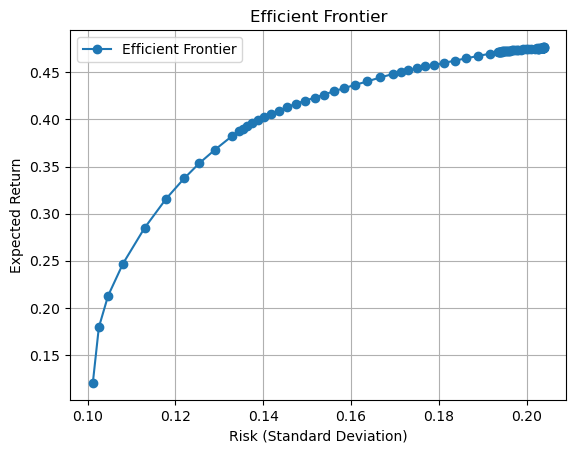

In [21]:
draw_ef(ef_set)

<img src="measurement.png" alt="measurement" style="float:left; height:400px; width:auto; border:1px solid black">

In [54]:
def difference(ucef,ccef):
    diff = 0
    x_diff_set = []
    y_diff_set = []

    sorted_ucef = np.array(sorted(ucef, key=lambda x: x[0]))
    sorted_ucef2 = np.array(sorted(ucef, key=lambda x: x[1]))
    y_values = sorted_ucef2[:, 1].astype(float)
    

    # 遍历第二个数组中的每个元素
    for a, b in ccef:
        
        # xj and yj_alt / xk and yk_alt
        # 二分查找大于a的最小x
        idx = np.searchsorted(sorted_ucef[:, 0], a, side='right')

        # 获取大于a的最小x及其对应的y
        if idx < len(sorted_ucef):
            xj, yj_alt = sorted_ucef[idx]
        else:
            xj, yj = a, b  # 如果不存在，返回None

        # 二分查找小于a的最大x
        idx_k = idx - 1

        # 获取小于a的最大x及其对应的y
        if idx_k >= 0:
            xk, yk_alt = sorted_ucef[idx_k]
        else:
            xk, yk_alt = a, b  # 如果不存在，返回None
            
            
        # yj xj_alt and yk xk_alt
            
        idx = np.searchsorted(y_values, b, side='right')
        
        # 获取大于 bi 的最小 y 及其对应的 x
        if idx < len(sorted_ucef2):
            xj_alt, yj = sorted_ucef2[idx]
        else:
            xj_alt, yj = a, b  # 如果不存在，返回 None
        
        # 二分查找小于 bi 的最大 y
        idx_k = idx - 1
        
        # 获取小于 bi 的最大 y 及其对应的 x
        if idx_k >= 0:
            xk_alt, yk = sorted_ucef2[idx_k]
        else:
            xk_alt, yk = a, b  # 如果不存在，返回 None
        
        # y* : item[0] x* : item[1]
        
        x_ss = xk_alt + (xj_alt - xk_alt)*(a - yk)/(yj - yk)
        y_ss = yk_alt + (yj_alt - yk_alt)*(b - xk)/(xj - xk)
        
        x_diff = abs(100 * (b - x_ss)/x_ss)
        y_diff = abs(100 * (np.sqrt(a) - np.sqrt(y_ss))/y_ss)
        
        x_diff_set.append(x_diff)
        y_diff_set.append(y_diff)
    
    return x_diff_set,y_diff_set   

In [30]:
ucef = [[5, 7], [7, 9], [12, 20], [14, 25]]
ccef = [[5, 6], [6, 10],[13,18],[15,23]]
x,y = difference(ucef,ccef)

In [58]:
%store -r ef_set

In [59]:
x,y = difference(ucef_set,ef_set)

In [60]:
def measurement(x_diff,y_diff):
    """
    Calculate measurement
    x_diff:risk_diff:standard deciation
    y_diff:return_diff
    """
    MEAPE = 0
    MEDPE = 0
    MINPE = 0
    MAXPE = 0
    for x,y in zip(x_diff,y_diff):
        MEAPE += min(x,y)
    MEAPE/=len(x_diff)
    MEDPE = min(np.median(x_diff),np.median(y_diff))
    MINPE = min(min(x_diff),min(y_diff))
    MAXPE = max(max(x_diff),max(y_diff))

    return MEAPE,MEDPE,MINPE,MAXPE

In [61]:
MEAPE,MEDPE,MINPE,MAXPE = measurement(x,y)
print(f"MEAPE:{MEAPE}")
print(f"MEDPE:{MEDPE}")
print(f"MINPE:{MINPE}")
print(f"MAXPE:{MAXPE}")

MEAPE:80.22590139542584
MEDPE:72.46527180458006
MINPE:2.0234565987741453
MAXPE:659.3689974426
